# Lab 3

Group 2 Members: Josh Mitchell, Adam Alidra, Ryan Herrin

This lab exercise is the third of three labs, completing our study of identifying obfuscated data present in PowerShell script. Through this process we've leveraged the complete data science lifecycle including various machine learning models to identify malicious code programmatically, enabling current and future data scientists to reuse this approach in an enterprise setting. 

The goal has and continues to be, proactively discovering obfuscated data in enterprise environments, mitigating the risk of downtime, data leaks, and irrevocable damage to organization's reputations.

In this particular lab, we use various clustering methods to provide insights that will empower cybersecurity analysts to prevent breaches.

In [1]:
#import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn import cluster
from sklearn import metrics
import scipy
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
from ps_obf import PS_OBF # Custom class 
%matplotlib inline
plt.style.use('ggplot')

Below is an object created from a custom class made at the beginning of this project. The class takes in our csv data and has a pipeline of steps that transforms the data and creates a PCA dataset from it. This PCA data can be used by assigning the PS_OBF.pca_df variable.

We landed on the PCA dataset over the other datasets we originally compared against as it isolated the features that had the most signficance relative to identifying obfuscation while producing the highest accuracy and lowest False Negatives, over other models we ran including KNN, Naive Bayes, and Logistic Regression. Recall, it's important in this particular study we don't let false negatives slip through the cracks given the serious risk unidentified obfuscated data presents.

Hence, the PCA dataset includes 10405 observations and 2 principal components which we will use to conduct clustering in Lab 3. Note, since Lab 3 compounds the work we previously conducted in Lab 1 and 2, data has been tidied, transformed, and no null values were originally present, therefore missing data is a nonfactor going forward.

In [2]:
ps_obf_data = PS_OBF('../dataset/all_with_keyword_sum.csv', transform=True)

# Assign PCA data 
pca_data = ps_obf_data.pca_df

This is a reminder of what the PCA data looks like on a scatter plot.

Text(0.5, 1.0, 'PCA Data')

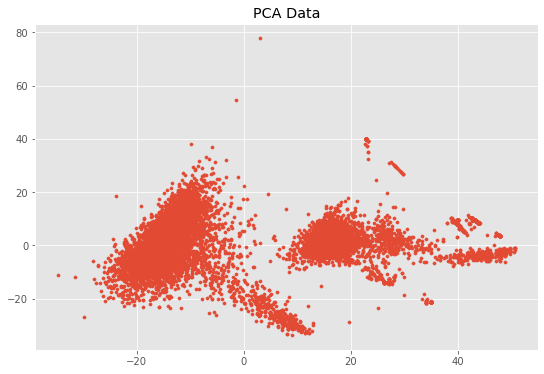

In [3]:
# Plot what the PCA data looks like on a scatter plot
plt.figure(figsize=(9, 6))
plt.scatter(pca_data[:,0], pca_data[:,1], s=10)
plt.title("PCA Data")

## DBSCAN

In this next section, we execute an unsupervised clustering machine learning algorithm, using DBSCAN, a density-based clustering of applications with noise. DBSCAN does not require pre-labeled targets to cluster data points, and is better suited than K-NNN, for example, to handle globular clusters and/or clusters of multiple sizes, with the added benefit of being robust to outliers.

DBSCAN typically requires two parameters, epsilon and minPoints. Epsilon is the max radius of the circle to be created around a data point while checking the distance between it and another data point to ultimately determine if the two points are similar enough to belong together. minPoints represents the minimum number of data points required within the radius of circle for the data point to be classified as a 'Core' point or broadly speaking, a cluster.

optimal epsilon: 1.1580238418147086


<Figure size 360x360 with 0 Axes>

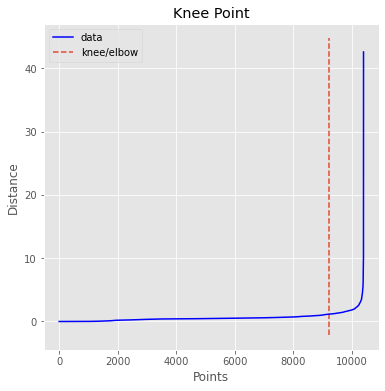

In [4]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(pca_data)

distances, indices = neighbors.kneighbors(pca_data)
distances = np.sort(distances[:,10], axis=0)

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print('optimal epsilon:', distances[knee.knee])

Above, we obtain an optimal epsilon value of 1.118, which is depicted through the knee point plot. To corroborate our programmatic findings, you'll see the plot displays the optimal value for epsilon occurring at the point of maximum curvature (right above '1' on the y-axis).

A lower epsilon value, like the 1.118 value we derived above, is generally a good indication the data points will be properly clustered, without either, missing too many data points, or merging clusters that should be independent.

In [5]:
#eps = 1.118403807740172
eps = distances[knee.knee]
v_measures = {}
df = ps_obf_data.data.copy()
for min_samples in range(1,100):
    # build and fit the model
    dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(pca_data)

    # get the number of clusters
    labels = dbscan.labels_
    num_clusters = len(set(labels))-(1 if -1 in labels else 0)
    #print('estimated number of clusters:', num_clusters)

    # identify noise
    n_noise = list(dbscan.labels_).count(-1)
    #print('estimated number of noise points:',n_noise)

    # calculate normalized mutual information score
    #print('v_measure =', v_measure_score(df['is_obf'], labels))
    v_measures[v_measure_score(df['is_obf'], labels)] = {'min_samples': min_samples, 'n_noise': n_noise, 'num_clusters': num_clusters}
mk = max(v_measures.keys())
print('best v-measure:', mk, v_measures[mk])

best v-measure: 0.483733340211274 {'min_samples': 3, 'n_noise': 165, 'num_clusters': 33}


0.10489118297648478

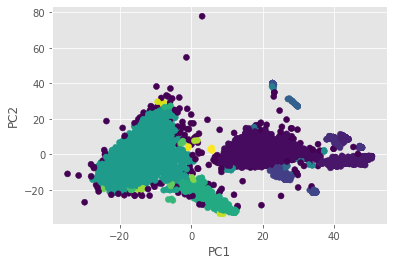

In [6]:
dbscan = cluster.DBSCAN(eps=eps, min_samples = v_measures[mk]['min_samples'])
dbscan.fit(pca_data)
plt.scatter(pca_data[:,0], pca_data[:,1], c=dbscan.labels_)
plt.xlabel("PC1")
plt.ylabel("PC2")
# silhouette score close to zero so we have some overlapping clusters and not well defined cluster boundaries
metrics.silhouette_score(pca_data, dbscan.labels_)

The DBSCAN algorithm on the PCA data generated 36 clusters with a minimum cluster size of 3 and an optimal epsilon of 1.1184. This resulted in 173 points being classified as noise and a calculate normalized mutual information score of 0.4787. Performing the silhouette score resulted in 0.01671. This value is close to zero and indicates that DBSCAN hash has some overlapping clusters and does not have well defined cluster boundaries.

Although the 36 clusters are interesting and deserve further investigation, the 173 noise data points suggest this algorithm is not optimal for the classification task.

# Find Number of Clusters with K-Means

Using the K-means to cluster the obfuscation PCA data. 


First step is to find the optimal number of clusters for the data using the elbow method. The elbow method is used by generating KMeans objects and fitting it to the data based on a range of defined clusters. Then for each number in the range of clusters we find the WCSS (Within-Cluster-Sum of Spuared Errors). We plot the WCSS on a a line chart. The point on the graph that looks like the line in dimenshing is the optimal number of clusters. The Elbow method may not show us a clear decision of how many clusters we need, although, there is another option using the silhouette method. The silhouette value measures how similar a point is to its own cluster compared to other clusters. In the graph generated we will be looking for the max value. Used in combination with the elbow plot we can be more confident about how many clusters is the most optimal. 

An important fact to note is that we previously know there should be two clusters. One for obfuscated code and one for non-obfuscated code, but we will go through the kmeans step to verify.

Text(0.5, 0, 'Clusters')

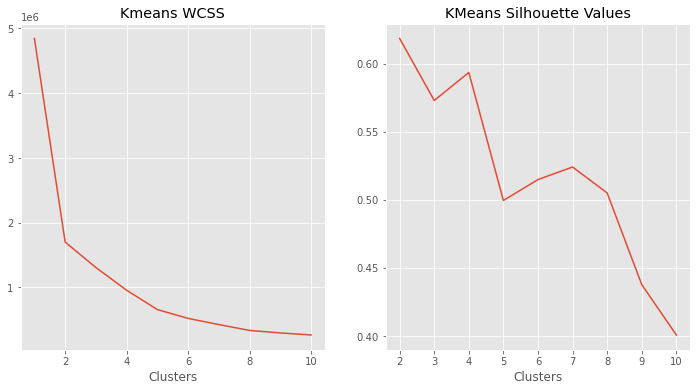

In [14]:
from sklearn.metrics import silhouette_score

# Find the optimal amount of K-means clusters using the elbow Method
def kmeans_wcss(dataframe, k_max_val):
    wcss_arry = [] # Within-Cluster-Sum-of-Squares

    for cluster_iter in range(1, 11): # range values are the number of clusters to test 
        tmp_kmeans = KMeans(
            n_clusters=cluster_iter, init='k-means++', max_iter=300, n_init=10, 
            random_state=ps_obf_data.rd_seed
            )

        tmp_kmeans.fit(pca_data)
        # Inertia is the sum of squared distances of samples to their closest cluster center
        wcss_arry.append(tmp_kmeans.inertia_)

    return(wcss_arry) # Return the array of wcss values 

# Using the Silhouette method
def kmeans_sil(dataframe, k_max_val): # Reuse the max_clusters var as k_max_val
    sil = []
    df = dataframe

    # Loop through a range of the number of clusters and generate a sil value 
    for k in range(2, k_max_val):
        # Generate the clusters and fit 
        kmeans = KMeans(
            n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=ps_obf_data.rd_seed 
        ).fit(df)
        labels = kmeans.labels_
        # Calculate the silhouette value and append to the sil list 
        sil.append(silhouette_score(df, labels, metric='euclidean'))

    return(sil)
        
# Define the max number of clusters to test for 
kmeans_max_clusters = 11

# Get the array of wcss values for the PCA data
kmeans_wcss_arry = kmeans_wcss(pca_data, kmeans_max_clusters)
# Get the silhouette values 
kmeans_sil_arry = kmeans_sil(pca_data, kmeans_max_clusters)

# Create Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(range(1, kmeans_max_clusters), kmeans_wcss_arry)
ax1.set_title("Kmeans WCSS");   ax1.set_xlabel("Clusters")
ax2.plot(range(2, kmeans_max_clusters), kmeans_sil_arry)
ax2.set_title("KMeans Silhouette Values");  ax2.set_xlabel("Clusters")

Here we can see using the elbow with the silhouette method that the optimal number of clusters is 2.

# K-Means Clustering

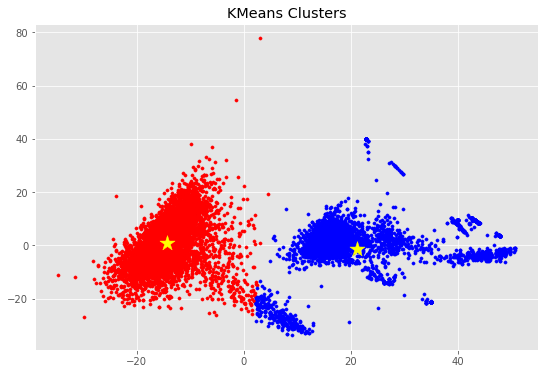

In [15]:
# Visualize our clusters with cetroids 
opt_clusters = 2 # Optimal number of clusters as found above

# Recreate the KMeans objust using the optimal clusters
kmeans = KMeans(n_clusters=opt_clusters, init='k-means++', max_iter=300, n_init=10, 
                random_state=None)
kmeans_y = kmeans.fit_predict(pca_data)

# Colors for the scatter plot clusters 
kmeans_colors = ['red', 'blue', 'green', 'cyan', 'magenta']

plt.figure(figsize=(9, 6)) # Size of the plot 
# Plot each cluster 
plt.scatter(pca_data[kmeans_y==0, 0], pca_data[kmeans_y==0, 1], s=10, c=kmeans_colors[0])
plt.scatter(pca_data[kmeans_y==1, 0], pca_data[kmeans_y==1, 1], s=10, c=kmeans_colors[1])
# Plot the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=250, marker='*', c='yellow')
plt.title("KMeans Clusters")
plt.show()

The K-Means Cluster shows a pretty significant cluster seperation between the left and right cluster. The bottom edge where it transitions between red to blue is, figuratively speaking, a gray area. The yellow stars in the middle of each cluster is the centroid. 

# Agglomerative Clustering

Agglomerative Clustering uses hierarchical clustering using the bottom up approach. Each observation starts in its own cluster, and clusters are successively merged together. We will exercise the 4 linkages: Single, Average, Complete, Ward. 

Text(0.5, 1.0, 'Single Linkage | Affinity: Cosine')

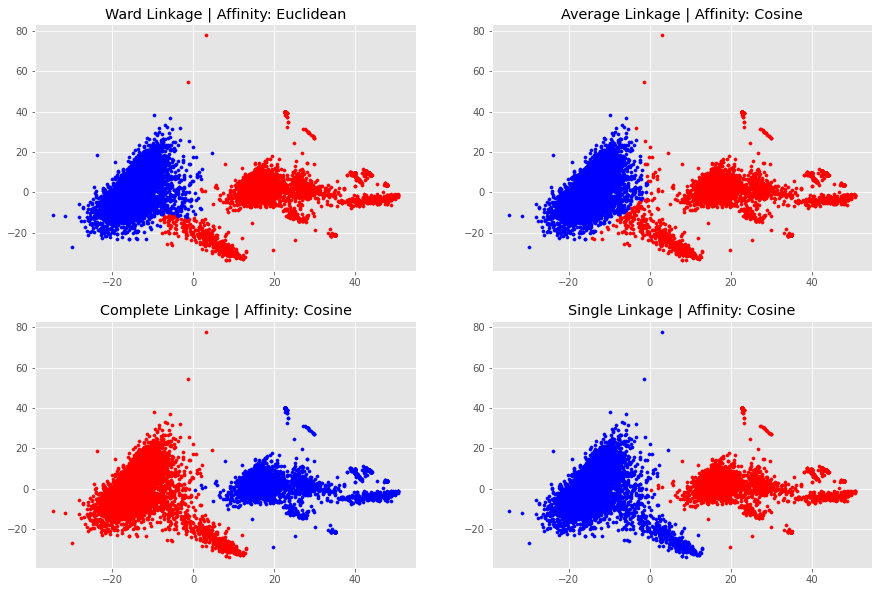

In [16]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

agglo_models = dict() # Dictionary to hold the different agglo linkage models

# Loop through each type of linkage to generate clustering
for link in ('ward', 'average', 'complete', 'single'):
    # Ward Linkage is required to use euclidean affinity
    if link == 'ward':
        agglo_cluster = AgglomerativeClustering(linkage=link, n_clusters=opt_clusters, affinity='euclidean')
    # Cosine affinity is used for the rest. Cosine focuses on the orientation of the vectors 
    # instead of the magnitude between points. 
    else:
        agglo_cluster = AgglomerativeClustering(linkage=link, n_clusters=opt_clusters, affinity='cosine')
    agglo_cluster.fit(pca_data)
    # Add Agglo Linkage model to dictionary
    agglo_models[link] = agglo_cluster

# Plot the Mulitple Agglo Linkage clusters 
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Ward
axs[0,0].scatter(pca_data[agglo_models["ward"].labels_==0, 0], pca_data[agglo_models["ward"].labels_==0, 1], 
    s=10, marker='o', color='red')
axs[0,0].scatter(pca_data[agglo_models["ward"].labels_==1, 0], pca_data[agglo_models["ward"].labels_==1, 1], 
    s=10, marker='o', color='blue')
# Average 
axs[0,1].scatter(pca_data[agglo_models["average"].labels_==0, 0], pca_data[agglo_models["average"].labels_==0, 1], 
    s=10, marker='o', color='red')
axs[0,1].scatter(pca_data[agglo_models["average"].labels_==1, 0], pca_data[agglo_models["average"].labels_==1, 1], 
    s=10, marker='o', color='blue')
# Complete 
axs[1,0].scatter(pca_data[agglo_models["complete"].labels_==0, 0], pca_data[agglo_models["complete"].labels_==0, 1], 
    s=10, marker='o', color='red')
axs[1,0].scatter(pca_data[agglo_models["complete"].labels_==1, 0], pca_data[agglo_models["complete"].labels_==1, 1], 
    s=10, marker='o', color='blue')
# Single 
axs[1,1].scatter(pca_data[agglo_models["single"].labels_==0, 0], pca_data[agglo_models["single"].labels_==0, 1], 
    s=10, marker='o', color='red')
axs[1,1].scatter(pca_data[agglo_models["single"].labels_==1, 0], pca_data[agglo_models["single"].labels_==1, 1], 
    s=10, marker='o', color='blue')

# Set the titles for each
axs[0,0].set_title("Ward Linkage | Affinity: Euclidean")
axs[0,1].set_title("Average Linkage | Affinity: Cosine")
axs[1,0].set_title("Complete Linkage | Affinity: Cosine")
axs[1,1].set_title("Single Linkage | Affinity: Cosine")

We tested the four Linkages for Agglomarative Cluster: ward, average, complete and single. The only other attribute that we changed was the affinity. Ward can only work with the Euclidean affinity, but the other linkages have other options. Those options were euclidean, l1, l2, manhattan, cosine, and precomputed. We tested all of these and found that only the cosine affinity was able to create seperable clusters. All the other affinities when tested would treat the entire data set (or nearly all the data) as one cluster while only finding a couple outliers and treating those as a seperate cluster. This could be beacause the cosine affinity measures the degree of angle between two vectors. Cosine looks at the orientation between the vectors as more important than the distance. 

Overall analysis of the charts would tell us that the "Complete Linkage | affinity: Cosine" and "Single Linkage | affinity: Cosine" are the two models to keep and test further. This is based on the seperation visually between the two clusters.  

# Gaussian Mixture (GMM)

Text(0.5, 1.0, 'GMM | Covariance: spherical')

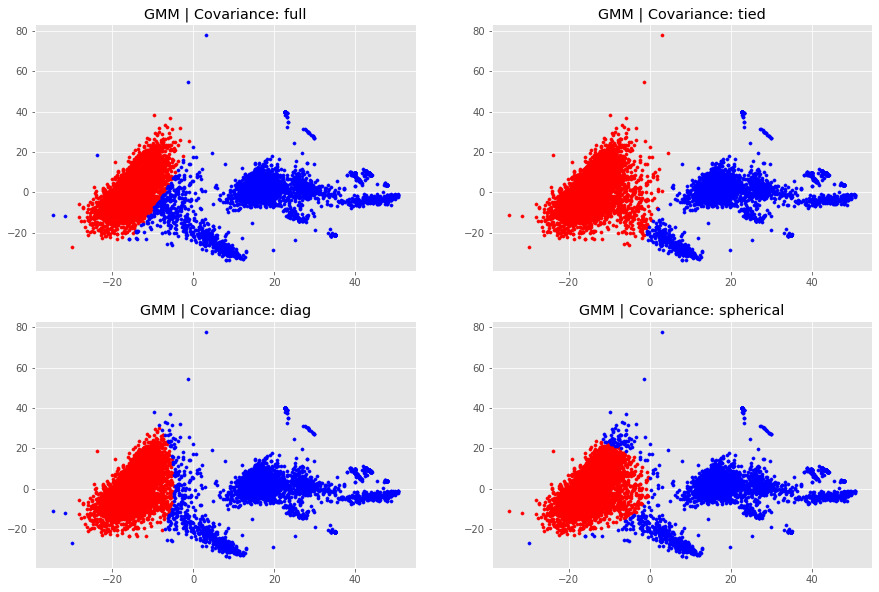

In [17]:
from sklearn.mixture import GaussianMixture

# Dictionary to hold the different agglo linkage models
gmm_mix_cov_y = dict()

# Create a loop to go through all "covariance_type" attributes 
for cov in ('full', 'tied', 'diag', 'spherical'):
    gmm_mix = GaussianMixture(
        n_components=opt_clusters, random_state=ps_obf_data.rd_seed, covariance_type=cov
        )
    # Add Predictions to dictionary that will be used to graph 
    gmm_mix_cov_y[cov] = gmm_mix.fit_predict(pca_data)

colors = ["navy", "darkorange"]

# Plot GMM predictions based on the different covariences  
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Covariance = Full
axs[0, 0].scatter(pca_data[gmm_mix_cov_y['full']==0, 0], pca_data[gmm_mix_cov_y['full']==0, 1], s=10, c='red')
axs[0, 0].scatter(pca_data[gmm_mix_cov_y['full']==1, 0], pca_data[gmm_mix_cov_y['full']==1, 1], s=10, c='blue')
# Covariance = Tied
axs[0, 1].scatter(pca_data[gmm_mix_cov_y['tied']==0, 0], pca_data[gmm_mix_cov_y['tied']==0, 1], s=10, c='red')
axs[0, 1].scatter(pca_data[gmm_mix_cov_y['tied']==1, 0], pca_data[gmm_mix_cov_y['tied']==1, 1], s=10, c='blue')
# Covariance = Diag
axs[1, 0].scatter(pca_data[gmm_mix_cov_y['diag']==0, 0], pca_data[gmm_mix_cov_y['diag']==0, 1], s=10, c='red')
axs[1, 0].scatter(pca_data[gmm_mix_cov_y['diag']==1, 0], pca_data[gmm_mix_cov_y['diag']==1, 1], s=10, c='blue')
# Covariance = Spherical
axs[1, 1].scatter(pca_data[gmm_mix_cov_y['spherical']==0, 0], pca_data[gmm_mix_cov_y['spherical']==0, 1], s=10, c='red')
axs[1, 1].scatter(pca_data[gmm_mix_cov_y['spherical']==1, 0], pca_data[gmm_mix_cov_y['spherical']==1, 1], s=10, c='blue')

# Set the titles for each
axs[0,0].set_title("GMM | Covariance: full")
axs[0,1].set_title("GMM | Covariance: tied")
axs[1,0].set_title("GMM | Covariance: diag")
axs[1,1].set_title("GMM | Covariance: spherical")

For the guassian mixture model we used the four covariances avaiable. Those covariances are full, diag, tied, and spherical. Guassian mixture models uses "spheres" and "circles" to create clusters. Because of the odd shapes of our clusters we can see that this clustering method is not the best suited for our use case. You can see on the plots where the elipses are visable. 

# Birch Clustering

An alternative to MiniBatchKmeans. It constructs a tree data structure with the cluster centroids being read off the leaf. There are not too many attributes to adjust so only one chart will be generated. 

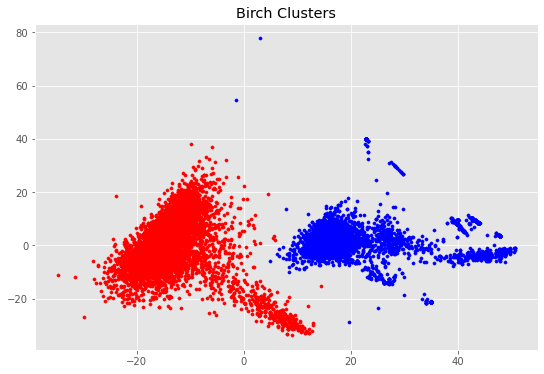

In [18]:
from sklearn.cluster import Birch

# Create the Birch Cluster Model
birch_cluster = Birch(n_clusters=opt_clusters, compute_labels=True)
# Get the predictions
birch_y = birch_cluster.fit_predict(pca_data)

plt.figure(figsize=(9, 6)) # Size of the plot 
# Plot each cluster 
plt.scatter(pca_data[birch_y==0, 0], pca_data[birch_y==0, 1], s=10, c='red')
plt.scatter(pca_data[birch_y==1, 0], pca_data[birch_y==1, 1], s=10, c='blue')
# Plot the centroids
plt.title("Birch Clusters")
plt.show()

The birch clustering performed well seperating the two clusters. It has performed very similar to the Agglomarative Clustering using the Single and Complete Linkage with the cosine afinity. The only difference is the top to ouliers being assinged to the right cluster, and a few other middle vectors switching sides. 

# Appendix
The source code for our custom ps_obf class. This class is stored in the same directory as our labs.

In [19]:
'''
Class to create a standardization for the way we process data for the is_obf project.

Proper Invocation:
----------------------------------

from ps_obf import PS_OBF

# Create Object
my_var = PS_OBF('../dataset/all_with_labels.csv', transform=True)
'''

import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


class PS_OBF:
	'''Class to create a standardization for the way we process data and create models.
	When the object is created a transformation will automatically happen that creates a
	new dataframe based on standard options, additional transofrmation will happen if
	set to true, and PCA models and dataframes will be created.

	@Params:
		csv_path (str) : Locations of the csv file
		transform (bool) : True to apply ratio transformation. False to apply standard transform
	'''
	def __init__(self, csv_path, transform=False):
		self.csv_path = csv_path
		self.transform = transform
		self.original_data = None
		self.data = None # working data that is modified
		self.rd_seed = 8675309
		self.pcs = None
		self.logreg = None
		self.pca_model = None
		self.pca_df = None
		self.pca_with_label_df = None
		self.train, self.test = None, None
		self.train_features, self.test_features = None, None
		self.train_labels, self.test_labels = None, None

		# Validate CSV Path or pandas will return read as a None type
		self._validate_csv_path()

		# Generate the transformation and models
		self._load_csv()

		# If transform is set to true and we want to modify data based on ratio
		if self.transform == True:
			self.transform_on_char_ratio()

		# Generate PCA data
		self._create_pca_objects()

	def _load_csv(self):
		'''Load CSV and turn into a pandas dataframe. Always calls the _standardize()
		to remove common features that were decided not to use. Also calls the
		_split() to split the data into train/test'''
		try:
			self.original_data = pd.read_csv(self.csv_path)
			self.data = self._standardize(self.original_data)

		except Exception as err:
			print(str(err))

		# Validate data and make sure that the data is not of type None
		if str(type(self.data)) == "<class 'NoneType'>" :
			raise Exception("Data was read in as Type:None. This should not happen...")

	def _validate_csv_path(self):
		'''Make sure the csv is valid before passing it to the pandas functions'''
		if os.path.exists(self.csv_path):
			pass
		else:
			raise Exception("CSV path is not a valid location...")

	def _standardize(self, dataframe):
		'''Function that is internally called to standardize the imported data. In short this
		removes the columns vt_harmless, vt_undetected, vt_malicious, vt_suspicious,
		avclass_name, obf_name, sha1, and fpath. It also keeps only the rows that have
		the lables 1 or 3.'''
		pd_df = dataframe
		unused_columns = ['vt_harmless', 'vt_undetected', 'vt_malicious', 'vt_suspicious',
						  'avclass_name', 'obf_name', 'sha1', 'fpath']
		# Remove Duplicates
		pd_df.drop_duplicates('sha1', inplace=True)

		# Check to see if duplicate header is present. Remove if there is
		if pd_df.at[0, 'sha1'] == 'sha1':
			pd_df = pd_df.iloc[1:]

		# Remove unused columns
		pd_df = pd_df.drop(columns=unused_columns)

		# Keep only the rows that are labled 1 or 3 in the "is_obf" column
		pd_df['is_obf'] = pd.to_numeric(pd_df['is_obf'], downcast='integer')
		pd_df.drop(pd_df.loc[pd_df['is_obf']==2].index, inplace=True)

		return(pd_df)

	def split(self, data, label_name='is_obf'):
		'''Splits the data into a 80/20 test split'''
		data = data

		# Dictionary to return
		split_decision = dict()

		# Check if the 'is_obf' column exists and add it to the DF if it isn't. This is most
		# likely to happen to the PCA data
		if data.shape[1] < 5:
			data = pd.DataFrame(data, columns=['PC1', 'PC2'])
			data['is_obf'] = self.data['is_obf'].to_numpy()
			self.pca_with_label_df = data

		# Get Train and test data
		train, test = train_test_split(data, test_size=.2, random_state=self.rd_seed)
		# Subsplit for featues and lables for train and split
		train_features = train[train.columns[train.columns != label_name]].to_numpy()
		test_features = test[test.columns[test.columns != label_name]].to_numpy()
		train_labels = train[train.columns[train.columns == label_name]].to_numpy().ravel()
		test_labels = test[test.columns[test.columns == label_name]].to_numpy().ravel()

		split_decision['train'] = train
		split_decision['test'] = test
		split_decision['train_features'] = train_features
		split_decision['test_features'] = test_features
		split_decision['train_labels'] = train_labels
		split_decision['test_labels'] = test_labels

		return(split_decision)

	def transform_on_char_ratio(self):
		"""Function to turn certain features from count to percentage (ratio) values. It
		does this be deviding the feature value by the document char count. Document char count
		is also a feature within the dataset and will be ignored along with some other features.
		This transformation will help try to mitigate the affects of scaling, because as the script
		gets larger than then char count would go up too.

		Returns transformed Pandas DataFrame
		"""
		working_data = self.data  # Create DF to return
		char_count_col_name = 'doc_char_count'

		# Remove dtypes and keyword features
		ftrs_to_rmv = []
		for feat in working_data.columns.tolist():
			if 'dtype_' in feat or 'keyword_' in feat:
				if feat != 'doc_keyword_totals':
					ftrs_to_rmv.append(feat)

		working_data.drop(ftrs_to_rmv, axis=1, inplace=True)

		# List of features that would not likely be susceptible to scaling issues
		non_sus_feat_lst = ['doc_char_count', 'doc_avg_line_len', 'doc_min_line_len',
					        'doc_line_count', 'doc_mcomment_count', 'doc_entropy', 'is_obf',
							'doc_max_line_len']#, 'doc_keyword_totals']

		# Start looping through the working data and change the values
		for row in list(working_data.index.values):
			for col_name in working_data.columns.tolist():
				# Skip columns that we don't want to modify
				if col_name not in non_sus_feat_lst:
					working_data.at[row, col_name] = float(
						float(working_data.at[row, col_name]) / float(working_data.at[row, char_count_col_name])
						) * 100
				else:
					pass

		# Drop Char count feature since it was used as the devisor
		working_data.drop('doc_char_count', axis=1, inplace=True)

		# Drop Entropy. Only concerened with counts / sum
		working_data.drop('doc_entropy', axis=1, inplace=True)

		# Drop Line Features
		line_features = ['doc_avg_line_len', 'doc_min_line_len', 'doc_line_count', 'doc_max_line_len',
				         'doc_mcomment_count']
		working_data.drop(line_features, axis=1, inplace=True)

		self.data = working_data

	def _create_pca_objects(self):
		'''Generate the PCA model and transformed dataset from it'''
		n_comps = 2

		# Temporarly copy and drop the target column
		delta_df = self.data.copy()
		delta_df = delta_df.drop(columns=['is_obf'])

		# Create PCA object and fit it
		pca = PCA(n_components=n_comps)
		x_pca = pca.fit(delta_df).transform(delta_df)

		# Assign PCA values to class variables
		self.pca_model = pca
		self.pca_df = x_pca
